<a href="https://colab.research.google.com/github/davideandres95/ml_comm/blob/main/tut02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Tutorial 2: Information Measures and Nonlinear Equalizer
October 28, 2021


## Table of Contents


*   1) Information Measures: 
*   2) How to build a NN in Pytorch:
*   3) Equalizer Example

In [ ]:
import numpy as np

import torch
from torch import nn, optim
import matplotlib.pyplot as plt

## 1) Information Measures 
### Expectation

 $$E[f(X)] = \sum_{a\in \chi}P_X(a)f(a) \approx \frac{1}{n} \sum_{i=1}^n f(x_i)$$


In [ ]:
pX = np.array( [0.5, 0.5])
chi = np.array([-1,1])
print('Theoretical expectation')
print(np.dot(pX, chi))
print('Empirical expectation as n grows larger:')
for n in (100,1000,10000,100000,100000):
    x = np.random.choice(chi, n, p=pX)
    print(np.mean(x))
    


Theoretical expectation
0.0
Empirical expectation as n grows larger:
-0.06
-0.002
0.003
-0.00324
-0.0038


### Entropy
 $$ H(X) = \sum_{a\in supp(P_X)} - P_X(a)\log_2 P_X(a) = E [-\log_2 P_X(X)]\approx - \frac{1}{n} \sum_{i=1}^n \log_2 P_X(x_i) $$

In [ ]:
pX = np.array([.1, .4, .4, .1]) 
chi = np.array([1,2,3,4])
entropy_teory = np.dot(-pX, np.log2(pX))
print(f'Theretical entropy: {entropy_teory:.3f}')
for n in (100, 1000, 1000000):
    x = np.random.choice(chi, n, p=pX)
    entropy = 0
    for i in chi:
        count = np.count_nonzero(x==i)
        pX_empirical = count / n
        entropy += -(count) * np.log2(pX_empirical) 
    
    entropy = entropy/n
    print(f'Empitrical entropy with {n} samples: {entropy}')
    


Theretical entropy: 1.722
Empitrical entropy with 100 samples: 1.7663232400493831
Empitrical entropy with 1000 samples: 1.696712365050515
Empitrical entropy with 1000000 samples: 1.72095820076875


## 2) Defining Neural Networks
In the following, we show two methods to create NNs in Pytorch.
### 1. nn.Sequential
We use nn.Sequential to create simple sequential NNs.

In [ ]:
net_seq = nn.Sequential(nn.Linear(1,4),
                    nn.ReLU(),
                    nn.Linear(4,4),
                    nn.ReLU(),
                    nn.Linear(4,1),
                    nn.Sigmoid())


print(net_seq)
print(net_seq[2])
print(net_seq.parameters)

Sequential(
  (0): Linear(in_features=1, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)
Linear(in_features=4, out_features=4, bias=True)
<bound method Module.parameters of Sequential(
  (0): Linear(in_features=1, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)>


### NN as subclass of nn.Module
We create our NN as a subclass of nn.Module. This gives us more flexibility in network design.
* Create NN as child class of nn.Module
* Use super() to inherit all the methods and properties from the partent class
* Define learnable parameters and forward propagation

In [ ]:
class Net(nn.Module):
    def __init__(self,num_units=4,with_sigmoid=True):
        print('creating NN with one hidden layer and {:d} units'.format(num_units))
        super().__init__()
        self.h1 = nn.Linear(1,num_units,bias=True)
        self.h2 = nn.Linear(num_units,num_units,bias=True)
        self.out = nn.Linear(num_units, 1, bias = False)
        self.act_h1 = nn.ReLU()
        self.act_h2 = nn.ReLU()
        if with_sigmoid:
            self.act_out = nn.Sigmoid()
        else:
            self.act_out = nn.Identity()
        
    def forward(self,x):
        x = self.act_h1(self.h1(x))
        x = self.act_h2(self.h2(x))
        x = self.act_out(self.out(x))
        return x
    
net = Net()
print(net)
print(net.parameters)

creating NN with one hidden layer and 4 units
Net(
  (h1): Linear(in_features=1, out_features=4, bias=True)
  (h2): Linear(in_features=4, out_features=4, bias=True)
  (out): Linear(in_features=4, out_features=1, bias=False)
  (act_h1): ReLU()
  (act_h2): ReLU()
  (act_out): Sigmoid()
)
<bound method Module.parameters of Net(
  (h1): Linear(in_features=1, out_features=4, bias=True)
  (h2): Linear(in_features=4, out_features=4, bias=True)
  (out): Linear(in_features=4, out_features=1, bias=False)
  (act_h1): ReLU()
  (act_h2): ReLU()
  (act_out): Sigmoid()
)>


## 3) Equalizer Example

In [ ]:
# Downsampling 
def downsample_td(signal, down):
    assert len(signal.shape)==2, 'signal format [number_dimensions][signal_length] expected'
    return down * signal[:, ::down]

# Tensor to Numpy
def t2n(x):
    return x.reshape(-1).detach().numpy()

# Sliding window 
def getchunks(x, num_taps):
    x = x.reshape(-1, 1)
    chunks = torch.zeros(x.shape[0], num_taps)
    for j in range(num_taps):
        chunks[:, j:j+1] = torch.roll(x, j - num_taps//2)
    return chunks


In [ ]:
# Define Neural Newtwork 
class EQ(nn.Module):
    def __init__(self, num_taps):
        super().__init__()
        self.num_taps = num_taps
        self.lin1 = nn.Linear(num_taps, 50)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(50, 50)
        self.act2 = nn.ReLU()
        self.lin3 = nn.Linear(50, 50)
        self.act3 = nn.ReLU()
        self.lin4 = nn.Linear(50, 1)

    def forward(self, y):
        y = getchunks(y, self.num_taps)
        y = self.act1(self.lin1(y))
        y = self.act2(self.lin2(y))
        y = self.act3(self.lin3(y))
        return self.lin4(y)

In [ ]:
# Load data
# https://drive.google.com/file/d/1LnsauugyC7-iK4EVlqghaEGZTPd6dfWG/view?usp=sharing
# https://drive.google.com/file/d/1RoN0BNuoEM3oDwYrkYvZd-KLDqfX1pHD/view?usp=sharing
!wget -O x.txt "https://drive.google.com/uc?export=download&id=1LnsauugyC7-iK4EVlqghaEGZTPd6dfWG"
!wget -O y.txt "https://drive.google.com/uc?export=download&id=1RoN0BNuoEM3oDwYrkYvZd-KLDqfX1pHD"

In [ ]:
# Prepare data
x = np.loadtxt('x.txt')
y = np.loadtxt('y.txt')
y_t = torch.Tensor(y.reshape(1, 1, -1))
x_t = torch.Tensor(x.reshape(1, -1))

ydown = downsample_td(np.reshape(y, (1,-1)),2)

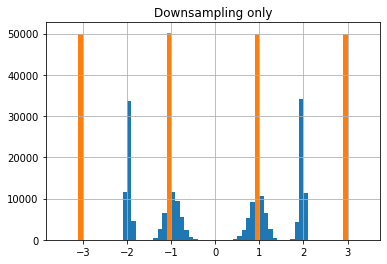

In [ ]:
# Plot data
plt.hist(ydown.reshape(-1), bins=np.arange(-3.5, 3.5, 0.1))
plt.hist(x.reshape(-1), bins=np.arange(-3.5, 3.5, 0.1))
plt.title('Downsampling only')
plt.grid()

In [ ]:
# Initialize Filter
num_taps = 41

whichfilter = 'nonlinear'

if whichfilter == 'linear':
    nn_filter = nn.Conv1d (in_channels=1 ,
                           out_channels=1 ,
                           kernel_size=num_taps,
                           padding='same' )
elif whichfilter == 'nonlinear':
    nn_filter = EQ(num_taps=3)


In [ ]:
# Define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(nn_filter.parameters(), lr=0.1)

epoch 0: Loss = 5.0784


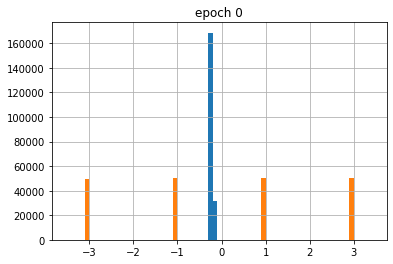

epoch 50: Loss = 0.0508


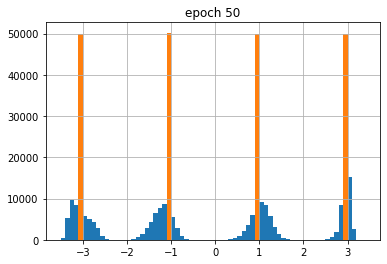

epoch 100: Loss = 0.0203


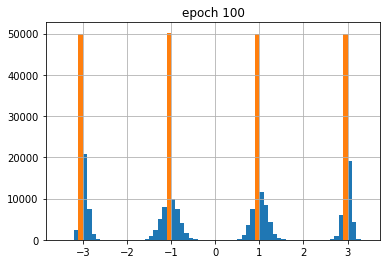

epoch 150: Loss = 0.0150


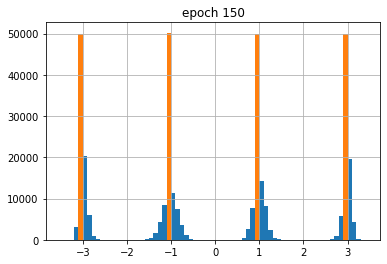

epoch 200: Loss = 0.0115


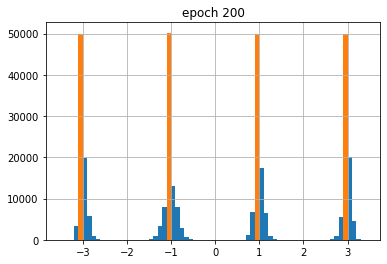

epoch 250: Loss = 0.0087


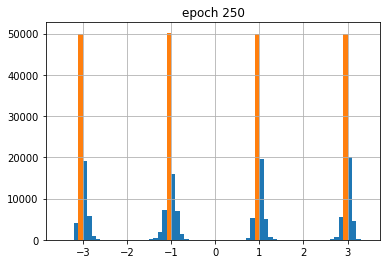

epoch 300: Loss = 0.0072


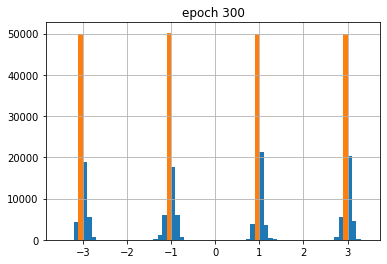

epoch 350: Loss = 0.0062


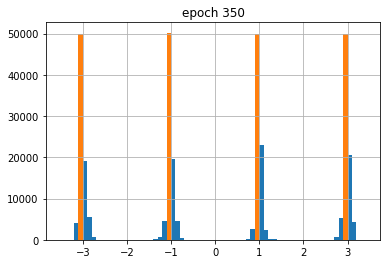

epoch 400: Loss = 0.0054


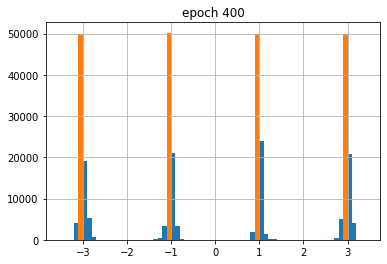

epoch 450: Loss = 0.0044


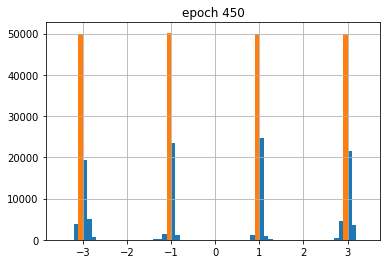

In [ ]:
# Trainings loop
for j in range(500):
    x_hat = nn_filter(y_t).reshape(1, -1)
    x_hat = downsample_td(x_hat, 2)
    loss = loss_fn(x_hat, x_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Printout and visualization
    if j % 50 == 0:
        print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')
        plt.hist(t2n(x_hat).reshape(-1), bins=np.arange(-3.5, 3.5, 0.1))
        plt.hist(x.reshape(-1), bins=np.arange(-3.5, 3.5, 0.1))
        plt.title(f'epoch {j}')
        plt.grid()
        plt.show()



#### Test on different data set

In [ ]:
# Load a new data set 
# https://drive.google.com/file/d/1-sgo0dxjocooZCrzOLarj8_mXJgKysdF/view?usp=sharing
# https://drive.google.com/file/d/1j9s0HfyBQv3kB93Pkcs7NlOqQKRId6yT/view?usp=sharing
!wget -O x1.txt "https://drive.google.com/uc?export=download&id=1-sgo0dxjocooZCrzOLarj8_mXJgKysdF"
!wget -O y1.txt "https://drive.google.com/uc?export=download&id=1j9s0HfyBQv3kB93Pkcs7NlOqQKRId6yT"


x1 = np.loadtxt('x1.txt')
y1 = np.loadtxt('y1.txt')
y1_t = torch.Tensor(y.reshape(1, 1, -1))
x1_t = torch.Tensor(x.reshape(1, -1))

# Comupute filter output
x1_hat = nn_filter(y1_t).reshape(1, -1)
# Downsample
x1_hat = downsample_td(x1_hat, 2)

# Compute loss
loss = loss_fn(x1_hat, x1_t)
print(f'Loss of the new data set: {loss.detach().numpy() :.4f}')


Loss of the new data set: 0.0035


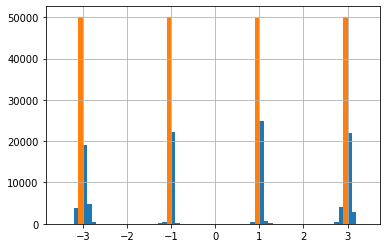

In [ ]:
# Plot 
plt.hist(t2n(x1_hat).reshape(-1), bins=np.arange(-3.5, 3.5, 0.1))
plt.hist(x1.reshape(-1), bins=np.arange(-3.5, 3.5, 0.1))
plt.grid()
plt.show()